### Contents:
- [1. Import Libraries](#1.-Import-Libraries)
- [2. Data Import](#2.-Data-Import)
- [3. Pre-Processing](#3.-Pre-Processing)
- [4. Model](#4.-Model)
- [5. Kaggle Submission](#5.-Kaggle-Submission)

## 1. Import Libraries
---

In [1]:
import pandas as pd
import requests
import time
import random
import string
import scipy.stats as stats
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve, mean_squared_error, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

## 2. Data Import
---

In [2]:
pd.set_option("display.max_columns", None)
train_final = pd.read_csv("../Datasets/train_final.csv")
test_final = pd.read_csv("../Datasets/test_final.csv")

## 3. Pre Processing
---

In [3]:
# set up train set
X_train = train_final.drop(columns = ['Address', 'Block', 'Street', 
                                      'AddressNumberAndStreet', 'Latitude', 'Longitude',
                                      'Species', 'Trap', 'AddressAccuracy',
                                      'tot_mosquitos','WnvPresent', 'month_year',
                                      'year', 'month', 'day',
                                      'tarsalis', 'erraticus', 'unspecified',
                                      'T040', 'T200B', 'T234', 
                                      'T090A', 'T090C', 'T090B', 
                                      'T218C', 'T128A', 'T218B', 
                                      'T218A', 'T002A', 'T002B', 
                                      'T200A', 'T065A', 'Unnamed: 0'])

y_train = train_final["WnvPresent"]

# set up test set
X_test = test_final.drop(columns = ['Address', 'Block', 'Street',
                                    'AddressNumberAndStreet', 'Latitude', 'Longitude',
                                    'Species', 'Trap', 'AddressAccuracy',
                                    'Id','month_year', 'year', 
                                    'month', 'day', 'tarsalis', 
                                    'erraticus', 'unspecified', 'T040', 
                                    'T200B', 'T234', 'T090A', 
                                    'T090C', 'T090B', 'T218C', 
                                    'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 
                                    'T065A', 'Unnamed: 0'])

In [4]:
# list of features to be scaled
scale_list = ['StnPressure', 'ResultSpeed','ResultDir',
              'DewPoint', 'DewPoint_roll2','DewPoint_roll3',
              'DewPoint_roll4','DewPoint_roll5', 'DewPoint_roll6',
              'Tavg', 'Tavg_roll2','Tavg_roll3',
              'Tavg_roll4','Tavg_roll5', 'Tavg_roll6',
              'PrecipTotal', 'PrecipTotal_roll2','PrecipTotal_roll3',
              'PrecipTotal_roll4','PrecipTotal_roll5','PrecipTotal_roll6']

# scaling
scaler = MinMaxScaler()
# scaling train set
X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
# scaling test set
X_test[scale_list] = scaler.transform(X_test[scale_list])

In [5]:
# SMOTE
sm = SMOTE(sampling_strategy = {1: 8000}, random_state = 42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

## 4. Model
---

In [6]:
# results to store the results for each model (dictionary)
results = {}

In [7]:
# Sample with a multinomial bayes model
pipe_nb = Pipeline([
    ("nb", MultinomialNB())
])

pipe_nb_params = {
    "nb__alpha": [0.1, 0.001, 0.0001, 1],
}

gs = GridSearchCV(
    pipe_nb,
    param_grid=pipe_nb_params,
    cv=5, 
    scoring = "roc_auc"
)

# fit grid search to training data
gs.fit(Xsm_train, ysm_train)

# save best model
nb_model = gs.best_estimator_

# prediction
nb_train_pred = nb_model.predict_proba(Xsm_train)
nb_test_pred = nb_model.predict_proba(X_test)

# confusion matrix
nb_train_cm = pd.DataFrame(confusion_matrix(ysm_train, nb_model.predict(Xsm_train)),
                           columns=["pred_wnv", "pred_no_wnv"],
                           index=["has_wnv", "has_no_wnv"])

tn, fp, fn, tp = confusion_matrix(ysm_train, nb_model.predict(Xsm_train)).ravel()

# other metrics       
sensitivity = tp / (tp + fn)    
specificity = tn / (tn + fp)   
precision = tp / (tp + fp)
roc_score = roc_auc_score(ysm_train, nb_train_pred[:, 1])

# append the metrics to "results" dictionary
results["nb"] = [nb_model.score(Xsm_train, ysm_train), 
                 sensitivity, 
                 specificity, 
                 precision, 
                 roc_score]

In [8]:
# accuracy score and roc score
print(f"Best Parameters: {gs.best_params_}")
print("Train accuracy score:", nb_model.score(Xsm_train, ysm_train))
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"ROC Score: {roc_score}")

Best Parameters: {'nb__alpha': 0.001}
Train accuracy score: 0.8616356094843063
Sensitivity: 0.87775
Specificity: 0.8458236232061818
Precision: 0.8481700688488948
ROC Score: 0.9331466178093953


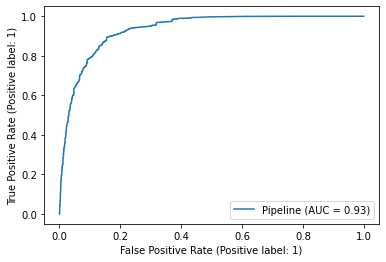

In [9]:
# roc auc curve
plot_roc_curve(nb_model, Xsm_train, ysm_train);

### Important Features

In [27]:
feature_names = list(Xsm_train.columns)
df = pd.DataFrame()
df["feature_names"] = feature_names
df = df.set_index(["feature_names"])
df["pos"] = np.exp(nb_model.named_steps["nb"].feature_log_prob_[1, :])
df["neg"] = np.exp(nb_model.named_steps["nb"].feature_log_prob_[0, :])

In [45]:
print("Top 20 features for positive class:\n", 
      pd.DataFrame(df.sort_values(by="pos", ascending=False).iloc[:20, 0]))

Top 20 features for positive class:
                         pos
feature_names              
DewPoint_roll2     0.057554
DewPoint_roll3     0.055564
Tavg               0.055341
DewPoint           0.054809
Tavg_roll2         0.053735
DewPoint_roll4     0.053400
DewPoint_roll6     0.053369
Tavg_roll3         0.053228
8                  0.052679
Tavg_roll4         0.051550
DewPoint_roll5     0.050711
Tavg_roll5         0.050034
Tavg_roll6         0.049849
StnPressure        0.041550
ResultDir          0.038458
pipiens/restuans   0.037859
pipiens            0.032007
ResultSpeed        0.026525
9                  0.019079
PrecipTotal_roll6  0.015580


In [48]:
print("Top 20 features for negative class:\n", 
      pd.DataFrame(df.sort_values(by="neg", ascending=False).iloc[:20, 1]))

Top 20 features for negative class:
                        neg
feature_names             
Tavg              0.051079
DewPoint_roll2    0.051042
DewPoint_roll3    0.048927
Tavg_roll2        0.048893
DewPoint          0.048864
Tavg_roll3        0.048275
Tavg_roll4        0.047315
DewPoint_roll6    0.046848
DewPoint_roll4    0.046782
Tavg_roll5        0.046230
Tavg_roll6        0.045891
DewPoint_roll5    0.044200
StnPressure       0.042567
ResultDir         0.039826
pipiens/restuans  0.037192
ResultSpeed       0.031092
8                 0.025632
restuans          0.023901
7                 0.021046
9                 0.018859


In [50]:
# number of features used in the model
len(Xsm_train.columns)

166

## 5. Kaggle Submission

In [13]:
nb_test_pred

array([[9.98388207e-01, 1.61179346e-03],
       [9.99519453e-01, 4.80546758e-04],
       [9.97240273e-01, 2.75972715e-03],
       ...,
       [9.90913004e-01, 9.08699562e-03],
       [9.90913004e-01, 9.08699562e-03],
       [9.90913004e-01, 9.08699562e-03]])

In [14]:
preds = []
for i in range(0,len(nb_test_pred)):
    preds.append(nb_test_pred[i][1])

In [15]:
# Prepare for kaggle
sample_submission_nb = pd.DataFrame()
sample_submission_nb['Id'] = test_final['Id']
sample_submission_nb['WnvPresent'] = preds
sample_submission_nb.reset_index(drop=True, inplace=True)
sample_submission_nb.to_csv('../Submissions/sample_submission_nb8.csv', index=False)

The Kaggle submission score for this Naive Bayes model is **0.71312**. 

Naive Bayes model tends to perform well when the input variables are categorical. Out of 166 input variables fed into this model, only 21 of those variables are numerical variables. The others are categorical variables. 

Naive Bayes model's main limitation is its assumption of independent predictors. This assumption is almost impossible to satisfy in reality as it is not possible to get a set of predictors that are completely independent. Moreover, looking at the top features of this model, there are some common features that are found to be important in predicting WNV, as well as, in predicting no WNV. For example, DewPoint_roll2 and DewPoint_roll3. Even though, this model seems to perform reasonably well and has one of the highest ROC score compared to the other models tested, it may not be suitable for this project.

Additionally, the kaggle score is much lower than the ROC score for the train set. Thus, highlighting that there may be overfitting in the model.